# REKOMENDACJE 

Pobieranie bibliotek oraz funkcja, która pozwala na pobieranie danych (playlisty) z podanego linku. W funkcji dokonujemy zapisu danych do pliku, zmian kolumn, one hot encodingu. Z funkcji otrzymujemy 2 ramki danych, encodowaną, która będzie potrzebna do modelu oraz podstawową, która pomoże w analizie danych. 

In [35]:
from extracting_data import extract
from utilis import *
import pandas as pd

def get_playlist_data(link, file_name): # tu będziemy otrzymać encodowane dane do rekomendacji i new_data czyli dane bez encodowania, które będą przydatne podczas analizy playlisty 
    extract(link, f'{file_name}.csv')
    new_data = pd.read_csv(f'{file_name}.csv')
    new_data.dropna(inplace=True, subset=['other'])
    create_new_column(new_data['other'], new_data)
    new_data.drop([new_data.columns[0]], axis=1, inplace=True)
    new_data['year'] = new_data['release date'].apply(change_date)
    new_data.drop(columns='release date', inplace=True)
    new_data['track genre'].fillna('Inne', inplace=True)
    new_data['new genre'] = new_data['track genre'].apply(change_genre)
    new_data.drop(columns='track genre', inplace=True)
    encoded_data = pd.get_dummies(new_data, columns=['new genre'], drop_first=True, dtype=int)
    return encoded_data, new_data

### Playlista, na podstawie której chcemy robić predykcje: 
https://open.spotify.com/playlist/61jNo7WKLOIQkahju8i0hw?si=68b94c0dfa854375

In [37]:
rock_playlist = 'https://open.spotify.com/playlist/61jNo7WKLOIQkahju8i0hw?si=68b94c0dfa854375'
playlist_encoded, playlist = get_playlist_data(rock_playlist, 'rap_test')

C:\Users\HP\AppData\Local\Temp\ipykernel_10784\4012265860.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_data['track genre'].fillna('Inne', inplace=True)


In [38]:
playlist

,track,artist,album,artist pop,track pop,duration,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,year,new genre
0,Can't Stop,Red Hot Chili Peppers,By the Way (Deluxe Edition),81,85,269000,0.618,0.938,-3.442,0.0456,0.0179,0,0.167,0.875,91.455,2002,rock
1,Immigrant Song - Remaster,Led Zeppelin,Led Zeppelin III (Remaster),74,77,146250,0.564,0.932,-10.068,0.0554,0.013,0.169,0.349,0.619,112.937,1970,rock
2,Heroes - 2017 Remaster,David Bowie,"""Heroes"" (2017 Remaster)",75,74,371413,0.489,0.758,-6.491,0.0297,0.000678,0.49,0.092,0.435,112.113,1977,rock
3,Push,Matchbox Twenty,Yourself or Someone Like You,65,73,238666,0.42,0.672,-7.902,0.027,0.0067,0,0.108,0.476,168.019,1996,other
4,Jump - 2015 Remaster,Van Halen,1984 (Remastered),70,77,241599,0.572,0.835,-6.219,0.0317,0.171,0.000377,0.0702,0.795,129.981,1984,rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Living in the 70's - 2009 Remaster,Skyhooks,Living In The 70's (2009 Remaster),37,47,222933,0.51,0.703,-5.99,0.0407,0.172,0,0.29,0.817,168.875,1974,rock
96,I Got You,Split Enz,True Colours,44,52,209440,0.676,0.581,-9.289,0.0373,0.0687,0.000904,0.152,0.827,126.298,1980,pop
97,Livin' On A Prayer,Bon Jovi,Slippery When Wet,77,85,249293,0.532,0.887,-3.757,0.0335,0.0778,0.000206,0.294,0.794,122.509,1986,metal
98,Come As You Are,Nirvana,Nevermind (Remastered),79,77,218920,0.5,0.824,-5.846,0.0388,0.00016,0.00161,0.0916,0.539,120.125,1991,other


In [39]:
playlist_num = playlist_encoded.drop(columns=['artist', 'album', 'track'])

### Skalowanie wartości od 0 do 1 
Jest to potrzebne, aby następnie wektory zostały dobrze obliczone. 

In [40]:
from sklearn.preprocessing import MinMaxScaler

def scale_data(data, column_names):
    df = pd.DataFrame(data, columns=column_names)
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_data, columns=column_names)
    return scaled_df

In [41]:
scaled_playlist = scale_data(data=playlist_num, column_names=playlist_num.columns)

In [42]:
spotify_data = pd.read_csv('spotify_data_encoded2.csv')
spotify_data.drop([spotify_data.columns[0]], axis=1, inplace=True)
spotify_data_num = spotify_data.drop(columns=['track', 'artist', 'album'])
spotify_data_scaled = scale_data(spotify_data_num, spotify_data_num.columns)

## Liczenie średnich wartości dla zadanej playlisty 
Tworzymy wektor średnich wartości ze wszystkich piosenek z playlisty dodanej przez użytkownika. 

In [43]:
column_averages = scaled_playlist.mean()
averages_cosine_sim = pd.DataFrame([column_averages], index=['Average'])
averages_cosine_sim

,artist pop,track pop,duration,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,year,new genre_other,new genre_pop,new genre_rock
Average,0.724231,0.756552,0.337793,0.445769,0.715487,0.644841,0.152315,0.106822,0.055717,0.236343,0.577245,0.45834,0.425667,0.13,0.07,0.65


### Synchronizacja kolumn
Funkcja ta jest potrzebna gdyż encodowaliśmy dane, dla zadanej playlisty liczba gatunków może być mniejsza niż dla całej bazy, a więc po one hot encodingu nie będzie nam się zgadzać liczba kolumn. Dlatego należy użyć poniższej funkcji. 

In [44]:
def synchronize_columns(df1, df2):
    missing_in_df2 = set(df1.columns) - set(df2.columns)
    missing_in_df1 = set(df2.columns) - set(df1.columns)
    
    for col in missing_in_df2:
        df2[col] = 0
        
    for col in missing_in_df1:
        df1[col] = 0
        
    df1 = df1[sorted(df1.columns)]
    df2 = df2[sorted(df2.columns)]
    
    return df1, df2

In [45]:
synchronize_columns(spotify_data_scaled, averages_cosine_sim)
averages_cosine_sim = averages_cosine_sim.sort_index(axis=1)
spotify_data_scaled = spotify_data_scaled.sort_index(axis=1)

### Uśredniony wektor 

In [46]:
averages_cosine_sim

,acousticness,artist pop,danceability,duration,energy,instrumentalness,liveness,loudness,new genre_classical,new genre_dance,...,new genre_other,new genre_pop,new genre_rap,new genre_rock,new genre_soul,speechiness,tempo,track pop,valence,year
Average,0.106822,0.724231,0.445769,0.337793,0.715487,0.055717,0.236343,0.644841,0,0,...,0.13,0.07,0,0.65,0,0.152315,0.45834,0.756552,0.577245,0.425667


# Rekomendacja nowych 20 piosenek 
Rekomendacja odbywa się za pomocą podobieństwa cosinusowego. Dla każdej piosenki w bazie tworzę wektor i sprawdzam podobieństwo tego wektora z uśrednionym wektorem z playlisty użytkownika. Im wartość większa, tym dwie piosenki są bardziej podobne/zbliżone do siebie. 

Aby rekomendacje nie zawierały piosenek znajdujących się już na playliście użytkownika, usuwam duplikaty. 

![cos](https://fineproxy.org/wp-content/uploads/2023/05/Cosine-similarity.jpg)



In [47]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_scores = cosine_similarity(spotify_data_scaled, averages_cosine_sim)
 
spotify_data['similarity_score'] = similarity_scores
 
new_frame = pd.merge(spotify_data, playlist, how='left', on='track')
top_similarities_filtered = new_frame[new_frame.isna().any(axis=1)]
top_similarities_filtered = top_similarities_filtered.sort_values(by='similarity_score', ascending=False)
top_similarities_filtered = top_similarities_filtered.drop_duplicates(subset=['track', 'artist_x'])
top_similarities_filtered[['track', 'artist_x', 'similarity_score']].head(20)


,track,artist_x,similarity_score
385,You Shook Me All Night Long,AC/DC,0.981242
757,When I Come Around,Green Day,0.980648
1669,Losing My Religion,R.E.M.,0.979764
2083,Somebody Told Me,The Killers,0.978131
890,Buddy Holly,Weezer,0.975467
302,Last Nite,The Strokes,0.974845
1800,Your Love,The Outfield,0.974211
311,Shut Up and Dance,WALK THE MOON,0.973110
1715,Don't Go Breaking My Heart,Elton John,0.972789
434,Jump,Van Halen,0.971743


# II WERSJA 
W drugiej wersji zanim dokonam liczenia podobieństw cosinusowych, klastruje dane za pomocą algorytmu KMeans. Uśredniony wektor, wyznaczony na tej samej zasadzie co wcześniej, klastruje za pomocą modelu. Wyznaczam podobieńśtwa cosinusowe między uśrednionym wektorem, a piosenkami, które znajdują się w tym samym klastrze co uśredniony wektor. 

## Klastrowanie danych 

In [48]:
spotify_data_scaled

,acousticness,artist pop,danceability,duration,energy,instrumentalness,liveness,loudness,new genre_classical,new genre_dance,...,new genre_other,new genre_pop,new genre_rap,new genre_rock,new genre_soul,speechiness,tempo,track pop,valence,year
0,0.324295,0.87,0.712788,0.252266,0.609896,0.000000,0.083394,0.901746,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.059379,0.445039,0.755319,0.327291,0.878788
1,0.029615,0.80,0.514675,0.400005,0.957881,0.000000,0.453343,0.981545,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.529015,0.818782,0.882979,0.816717,0.772727
2,0.128511,0.82,0.226415,0.381320,0.497578,0.000002,0.092694,0.841030,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.050067,0.883512,0.861702,0.315206,0.924242
3,0.955823,0.86,0.441300,0.424302,0.130539,0.004613,0.090627,0.615540,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.051552,0.648318,0.861702,0.120846,0.924242
4,0.272086,0.81,0.430818,0.526422,0.404314,0.000000,0.288002,0.799809,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.068961,0.335220,0.851064,0.227593,0.257576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2117,0.000098,0.68,0.335430,0.428881,0.881665,0.000004,0.056526,0.884136,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.068016,0.690312,0.776596,0.258812,0.651515
2118,0.000141,0.53,0.315514,0.334584,0.824503,0.000315,0.064069,0.926656,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.058435,0.717048,0.648936,0.374622,0.636364
2119,0.002918,0.67,0.502096,0.348369,0.930804,0.298371,0.154697,0.904259,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.124291,0.754462,0.542553,0.346425,0.712121
2120,0.023089,0.78,0.572327,0.414268,0.815478,0.000000,0.078433,0.903392,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.042375,0.495179,0.808511,0.147029,0.696970


### Na samym początku musimy znaleźć odpowiednią liczbe klastrów. Do tego zadania sprawdzam wartość silhoute dla liczby klastrów z przedziału od 2 do 10. 
Silhouette score mierzy, jak dobrze są oddzielone klastry oraz jak bardzo są spójne. Wartość wskaźnika sylwetki mieści się w przedziale od -1 do 1, przy czym wyższe wartości wskazują na lepiej zdefiniowane klastry:

Dla każdej próbki oblicza się średnią odległość do wszystkich innych punktów w tym samym klastrze (to jest a).
Dla każdej próbki oblicza się średnią odległość do wszystkich punktów w najbliższym klastrze, do którego próbka nie należy (to jest b).
![si](https://miro.medium.com/v2/resize:fit:1130/1*F3ACNY6wYAzR-kr6yTattQ.png)

In [49]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
n_clusters = range(2,10)
ssd = []
sc = []

for n in n_clusters:
    km = KMeans(n_clusters=n, max_iter=300, n_init=10, init='k-means++', random_state=42)
    km.fit(spotify_data_scaled)
    preds = km.predict(spotify_data_scaled) 
    centers = km.cluster_centers_ 
    ssd.append(km.inertia_) 
    score = silhouette_score(spotify_data_scaled, preds, metric='euclidean')
    sc.append(score)
    print("Number of Clusters = {}, Silhouette Score = {}".format(n, score))

Number of Clusters = 2, Silhouette Score = 0.2057629265975347
Number of Clusters = 3, Silhouette Score = 0.2802811844782773
Number of Clusters = 4, Silhouette Score = 0.33507397098402714
Number of Clusters = 5, Silhouette Score = 0.36197216546726263
Number of Clusters = 6, Silhouette Score = 0.3869375448106264
Number of Clusters = 7, Silhouette Score = 0.40889914935165084
Number of Clusters = 8, Silhouette Score = 0.4254093768224651
Number of Clusters = 9, Silhouette Score = 0.39724663726804355


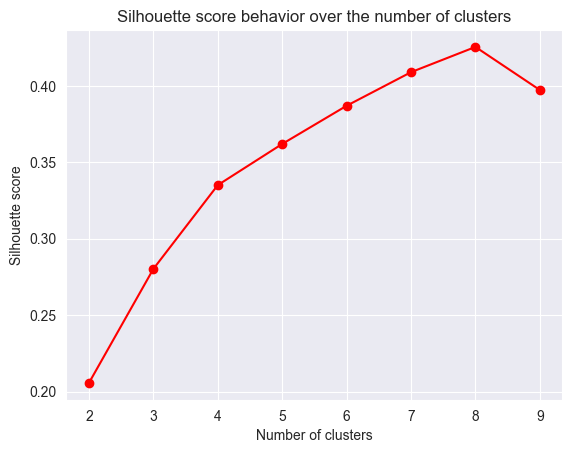

In [50]:
from matplotlib import pyplot as plt

plt.plot(n_clusters, sc, marker='.', markersize=12, color='red')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score behavior over the number of clusters')
plt.show()

### Drugą metryką oceny jest sprawdzenie jak prezentuję się kwadratowa suma odległości punktów. 
SSD oblicza się poprzez zsumowanie kwadratowych odległości między wszystkimi parami punktów danych w obrębie klastra. Dla klastra C zawierającego n punktów danych, SSD jest dane wzorem:

SSD = Σᵢⱼ (xᵢ - xⱼ)²
gdzie:

xᵢ i xⱼ są punktami danych w klastrze C

Niższa wartość SSD ogólnie wskazuje na ściślejszy, bardziej spójny klaster, ponieważ punkty danych są średnio bliżej siebie. Z kolei wyższa wartość SSD sugeruje bardziej rozproszony lub luźno zdefiniowany klaster.

In [51]:
for n, s in zip(n_clusters, ssd):
    print('Number of Clusters = {}, Sum of Squared Distances = {}'.format(n, s))

Number of Clusters = 2, Sum of Squared Distances = 2337.5534205441118
Number of Clusters = 3, Sum of Squared Distances = 1921.6850379388738
Number of Clusters = 4, Sum of Squared Distances = 1643.3047050150944
Number of Clusters = 5, Sum of Squared Distances = 1408.0365808980418
Number of Clusters = 6, Sum of Squared Distances = 1277.5228738819746
Number of Clusters = 7, Sum of Squared Distances = 1169.5368671013598
Number of Clusters = 8, Sum of Squared Distances = 1085.0970063833865
Number of Clusters = 9, Sum of Squared Distances = 1007.7689705416141


### Znanym sposobem do znalezienia optymalnej liczby klastrów, przy użyciu obliczonych SSD, jest metoda tzw. łokcia, która pozwala patrząc na wykres znaleźć optymalną liczbę klastrów. 

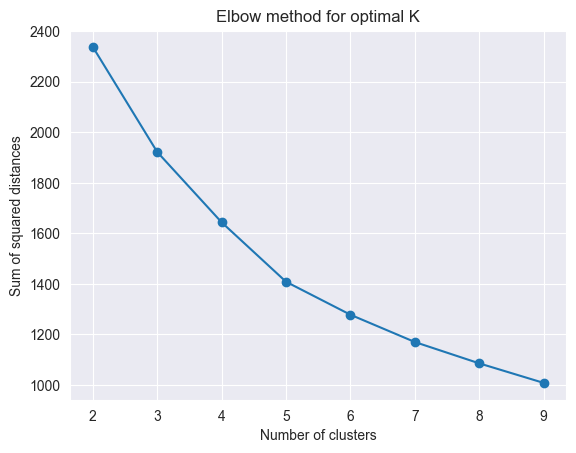

In [52]:
plt.plot(n_clusters, ssd, marker='.', markersize=12)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method for optimal K')
plt.show()

### Dodatkowo można sprawdzić silhoute score na wykresach tzw. silhoute plot, aby ocenić jaka liczba klastrów jest najbardziej optymalna.

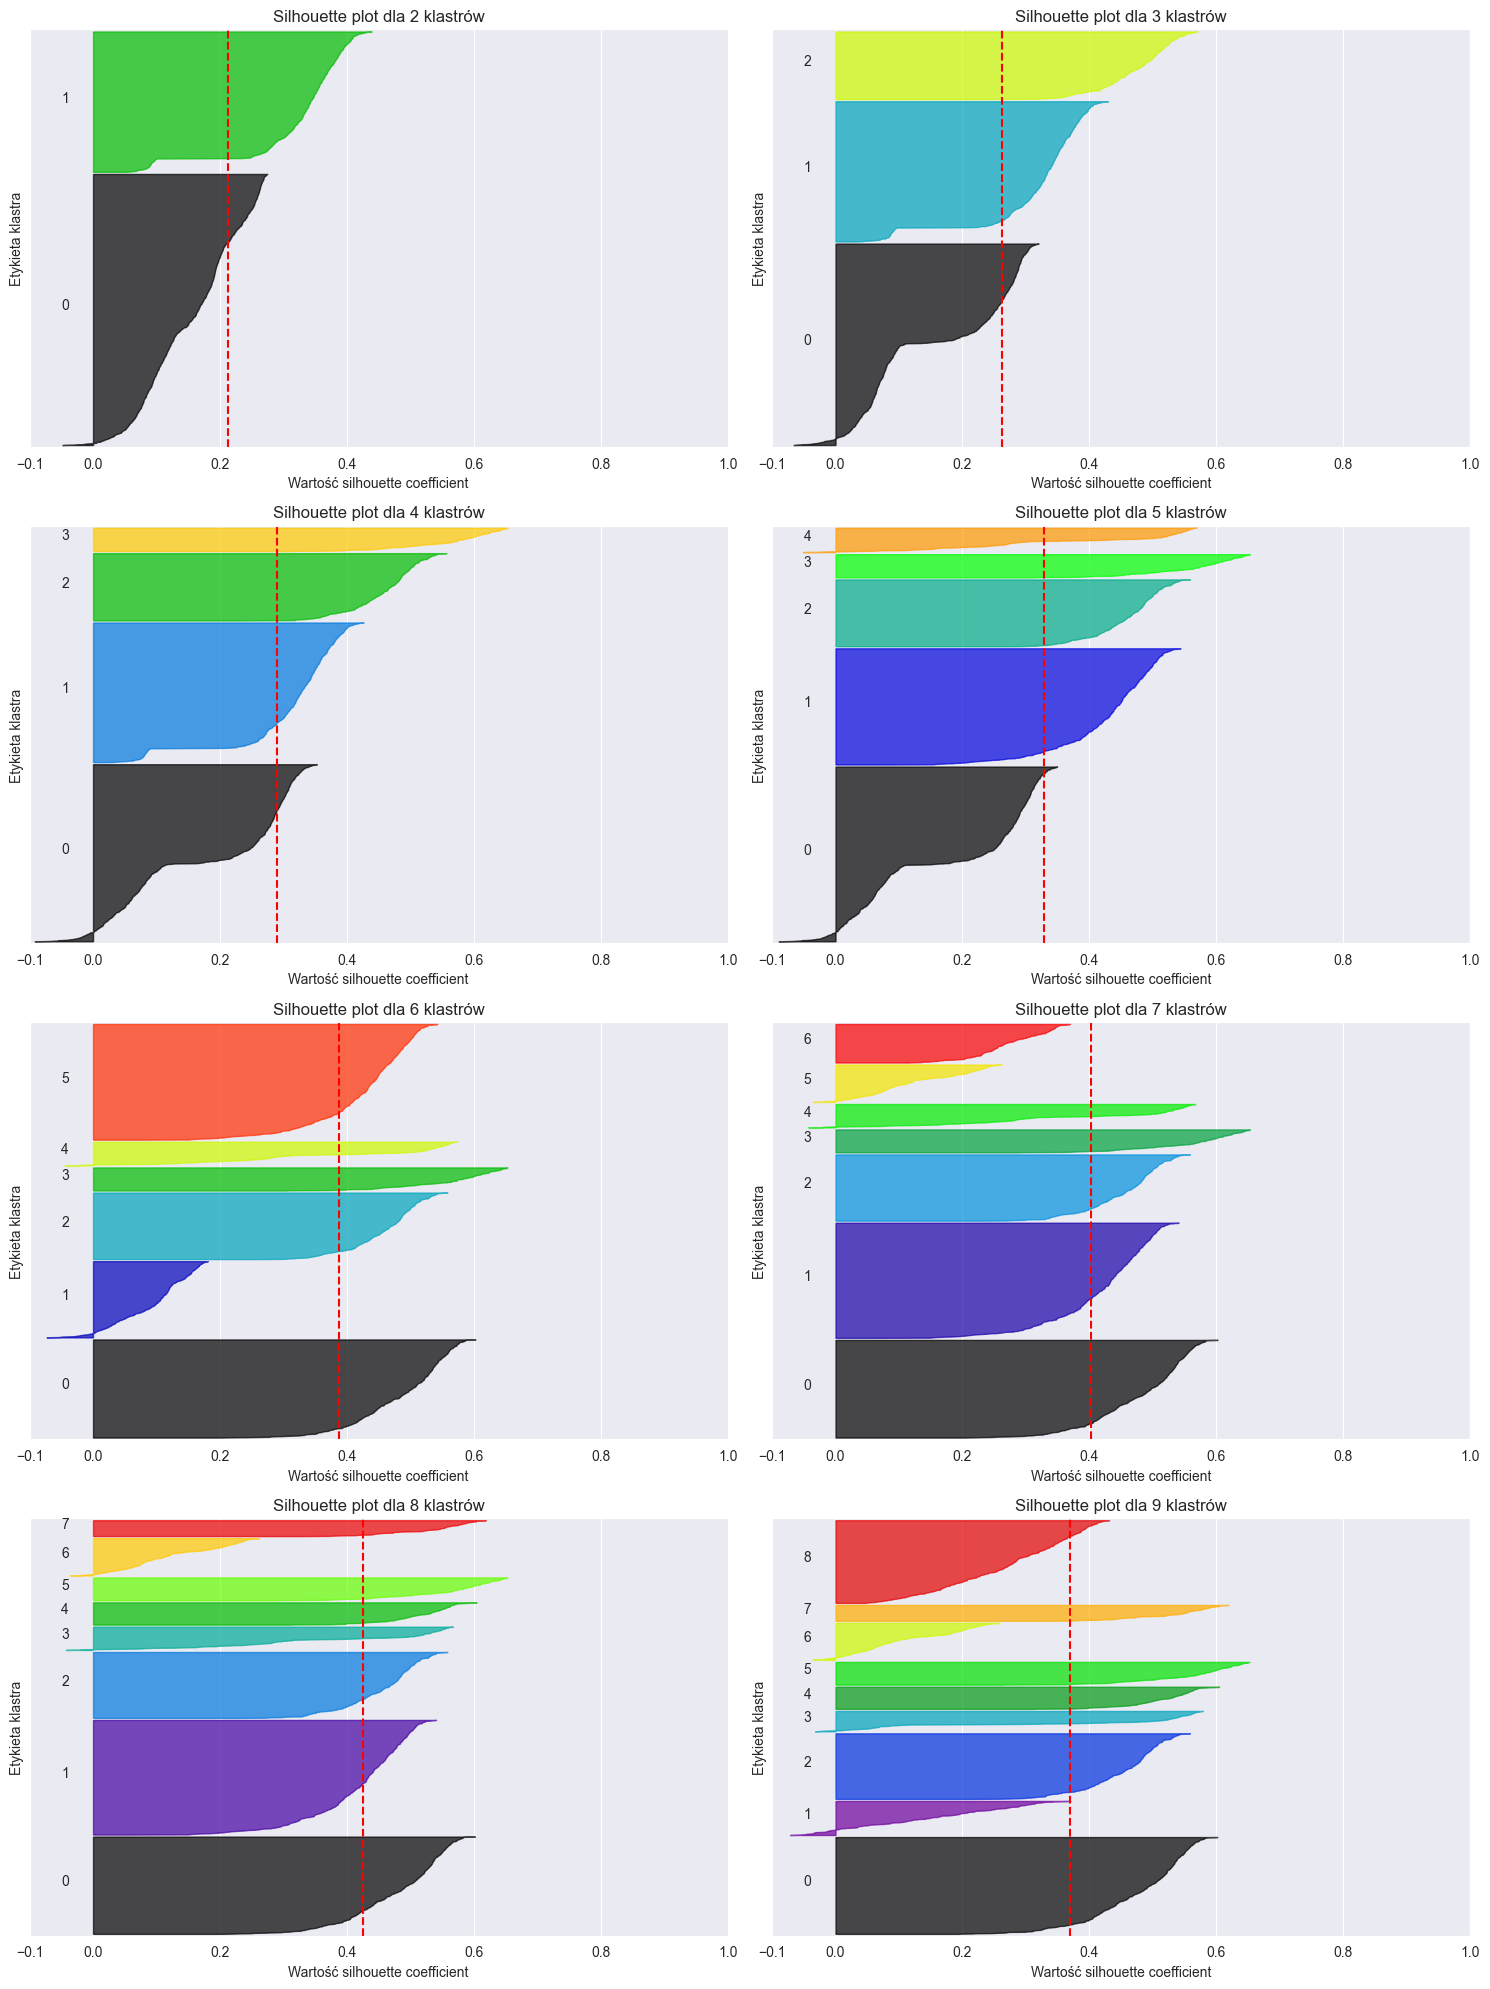

In [53]:
from sklearn.metrics import silhouette_samples
import numpy as np
import matplotlib.pyplot as plt

n_clusters_range = range(2, 10)
silhouette_scores = []

fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()

for idx, n_clusters in enumerate(n_clusters_range):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(spotify_data_scaled)
    
    silhouette_avg = silhouette_score(spotify_data_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    sample_silhouette_values = silhouette_samples(spotify_data_scaled, cluster_labels)
    
    ax = axes[idx]
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(spotify_data_scaled) + (n_clusters + 1) * 10])

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  

    ax.set_title(f"Silhouette plot dla {n_clusters} klastrów")
    ax.set_xlabel("Wartość silhouette coefficient")
    ax.set_ylabel("Etykieta klastra")
    
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([]) 
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.tight_layout()
plt.show()

### Z powyższych wykresów i wartości wskaźników wychodzi, że najbardziej optymalną liczbą klastrów jest liczba 5. 

In [54]:
k=5
model = KMeans(n_clusters=k, random_state=42).fit(spotify_data_scaled)
pred = model.predict(spotify_data_scaled)

### Sprawdzenie liczby elementów w każdym klastrze. 

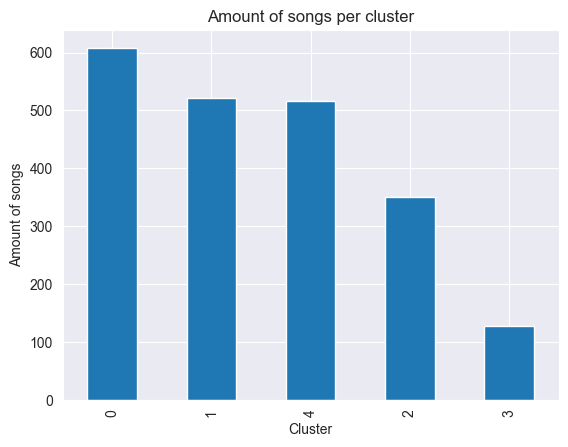

In [55]:
spotify_data['cluster'] = model.labels_
spotify_data_scaled['cluster'] = model.labels_
spotify_data['cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Amount of songs')
plt.title('Amount of songs per cluster')
plt.show()

### Pokazanie 10 elementów z każdego klastra. 
Można zauważyć, że faktycznie piosenki mają podobny typ wewnątrz klastrów np. 1 klaster typowo zbiera amerykański hip hop, a 2 piosenki rockowe, w natomiast mamy mało popularne piosenki solowo-jazzowe. Najbardziej zbliżone względem piosenek są klastry 0 i 3.

In [56]:
for cluster in range(k):
    display(spotify_data[spotify_data['cluster'] == cluster][['artist', 'track', 'album']].head(10))

,artist,track,album
8,The Weeknd,The Hills,Beauty Behind The Madness
9,One Direction,History,Made In The A.M. (Deluxe Edition)
16,Little Mix,Secret Love Song (feat. Jason Derulo),Get Weird (Deluxe)
18,Marshmello,Happier,Happier
35,The Wanted,Walks Like Rihanna,Word Of Mouth (Deluxe)
42,Alan Walker,Faded,Faded
52,Macklemore & Ryan Lewis,Can't Hold Us (feat. Ray Dalton),The Heist
69,One Direction,What Makes You Beautiful,Up All Night
70,One Direction,Story of My Life,Midnight Memories (Deluxe)
71,One Direction,Drag Me Down,Made In The A.M. (Deluxe Edition)


,artist,track,album
1,JAY-Z,Empire State Of Mind,The Blueprint 3
2,"Tyler, The Creator",ARE WE STILL FRIENDS?,IGOR
6,Eminem,Without Me,The Eminem Show
14,Sia,Cheap Thrills (feat. Sean Paul),Cheap Thrills (feat. Sean Paul)
25,Sia,Chandelier,Chandelier
58,Roddy Ricch,The Box,Please Excuse Me for Being Antisocial
79,Alicia Keys,Girl on Fire,Girl on Fire (Remixes) - EP
88,CeeLo Green,Forget You,The Lady Killer (The Platinum Edition)
104,Tourist LeMC,En Route,En Route
105,Arno,Les yeux de ma mère (en concert),En concert (À la française)


,artist,track,album
4,Queen,Bohemian Rhapsody - Remastered 2011,A Night At The Opera (2011 Remaster)
5,Arctic Monkeys,Why'd You Only Call Me When You're High?,AM
44,Journey,Don't Stop Believin',Flash Back Internacional
49,The Script,Hall of Fame (feat. will.i.am),#3 Deluxe Version
53,Mumford & Sons,I Will Wait,Babel
55,Panic! At The Disco,High Hopes,High Hopes on Saturday Night
73,OneRepublic,Counting Stars,Native
82,Queen,Another One Bites The Dust - Remastered 2011,The Game (2011 Remaster)
89,WALK THE MOON,Lost In The Wild,What If Nothing
100,Queen,Love Of My Life - Remastered 2011,A Night At The Opera (Deluxe Edition 2011 Rema...


,artist,track,album
130,Lévon Minassian,Siretzi Yares Daran (They Have Taken the One I...,The Doudouk - Beyond Borders
131,Ibrahim Maalouf,True Sorry,Illusions
132,Rabih Abou-Khalil,Sahara,Blue Camel
155,John Cage,Experiences No. 2,Different Every Time
156,Philip Glass,The Poet Acts,The Hours (Music from the Motion Picture Sound...
183,David Gilmour,Red Sky at Night,On an Island
189,Kokoroko,Abusey Junction,We out Here
193,Agnes Obel,September Song,Aventine (Deluxe)
686,"Bobby ""Blue"" Bland",Ain't No Love In The Heart Of The City - Singl...,Dreamer
831,Jack Stauber's Micropop,Just Take My Wallet,Micropop


,artist,track,album
0,Rihanna,Desperado,ANTI (Deluxe)
3,Billie Eilish,i love you,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?"
7,Ariana Grande,no tears left to cry,no tears left to cry
10,Bruno Mars,Grenade,Doo-Wops & Hooligans
11,Sam Smith,Stay With Me,In The Lonely Hour (Deluxe Edition)
12,Jonas Blue,Rise,Rise
13,Ava Max,Sweet but Psycho,Sweet but Psycho
15,P!nk,What About Us,Beautiful Trauma
17,Beyoncé,Halo,I AM...SASHA FIERCE
19,Jonas Blue,Fast Car,Fast Car


## Pokazanie rozróżnienia cech piosenek względem klastrów. 

In [57]:
column_to_radar = ['danceability', 'energy', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence']
df_radar = spotify_data_scaled.groupby('cluster')[column_to_radar].mean().reset_index()
df_radar

,cluster,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence
0,0,0.632475,0.643606,0.098380,0.246058,0.048864,0.171485,0.473363
1,1,0.613195,0.645905,0.134472,0.231886,0.031729,0.183331,0.469106
2,2,0.549949,0.673994,0.075914,0.173076,0.039967,0.178854,0.511417
3,3,0.312163,0.062864,0.071389,0.964409,0.840152,0.092398,0.148871
4,4,0.661409,0.634658,0.101189,0.264234,0.030362,0.163416,0.513985


In [58]:
import math
import numpy as np
def make_radar(row, title, color, dframe, num_clusters):
    categories=list(dframe)[1:]
    N = len(categories)
    
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    ax = plt.subplot(2,math.ceil(num_clusters/2),row+1, polar=True, )
    
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories, color='grey', size=14)

    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=8)
    plt.ylim(0,1)

    values=dframe.loc[row].drop('cluster').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    plt.title(title, size=16, color=color, y=1.06)

C:\Users\HP\AppData\Local\Temp\ipykernel_10784\2776452684.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_palette = plt.cm.get_cmap("brg", len(df_radar.index))


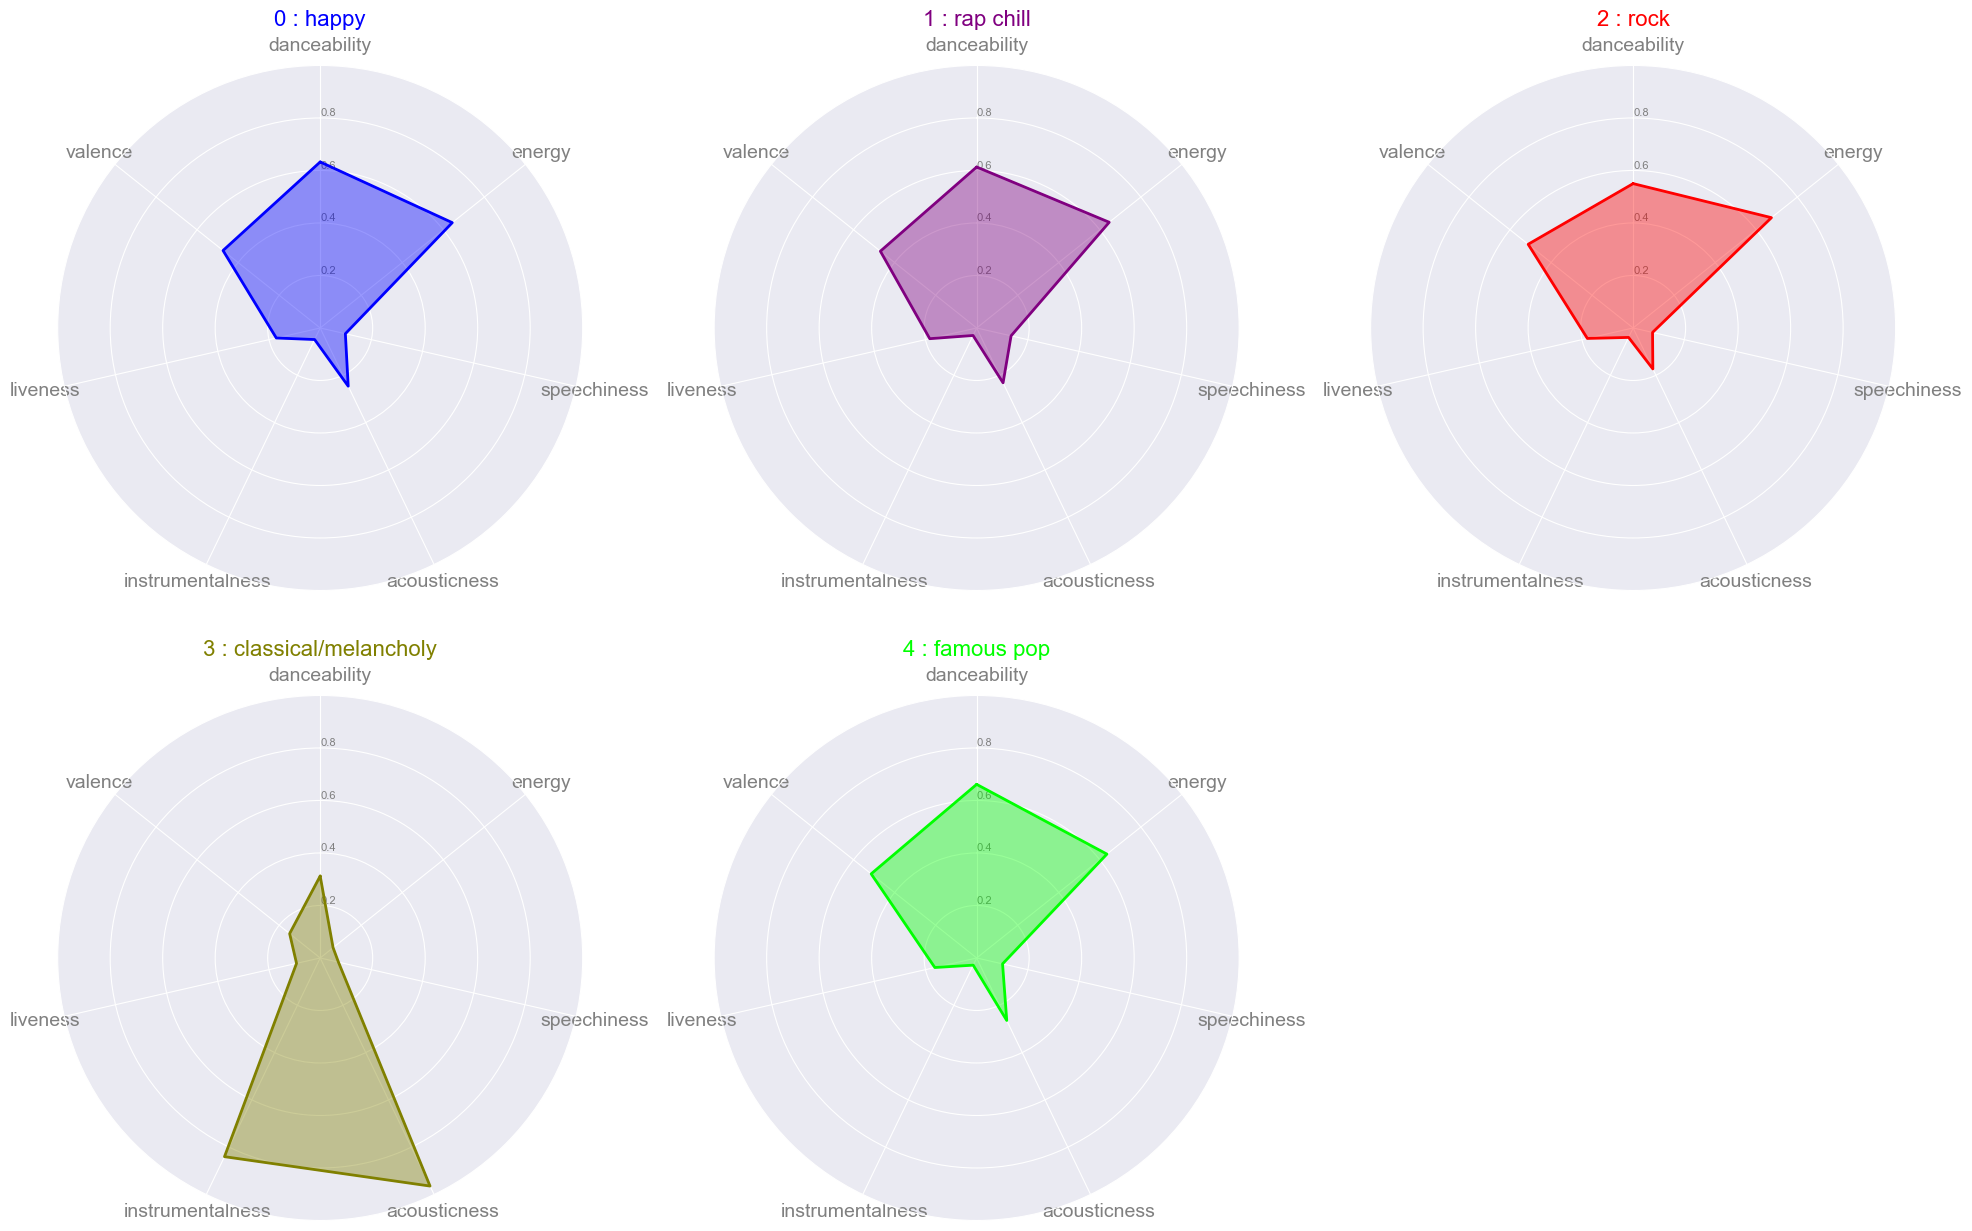

In [59]:
plt.figure(figsize=(24,15))
my_palette = plt.cm.get_cmap("brg", len(df_radar.index))

title_list = ['happy', 'rap chill', 'rock', 'classical/melancholy', 'famous pop']
for row in range(0, len(df_radar.index)):
    make_radar(row=row, title=str(df_radar['cluster'][row]) + ' : ' + title_list[row], 
               color=my_palette(row), dframe=df_radar, num_clusters=len(df_radar.index))

## Pokazanie klastrów w dwuwymiarze. 
Aby tego dokonać korzystamy z PCA, liczba komponentów to 2, gdyż chcemy je pokazać na dwumiarowym układzie współrzędnych. 

In [60]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
songs_pca = pca.fit_transform(spotify_data_scaled)
pca.explained_variance_ratio_.sum()

0.7607713527017245

In [61]:
df_pca = pd.DataFrame(songs_pca, columns=['C1', 'C2'])
df_pca['cluster'] = model.labels_
df_pca.head()

,C1,C2,cluster
0,2.402999,0.101784,4
1,-0.714773,-0.614857,1
2,-0.699086,-0.172628,1
3,2.430933,0.695998,4
4,0.294256,-0.453995,2


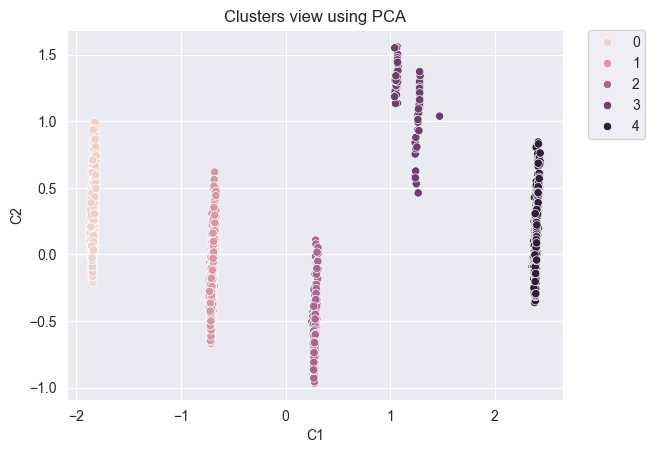

In [62]:
import seaborn as sns 
sns.scatterplot(x='C1', y='C2', hue='cluster', data=df_pca, legend="full")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Clusters view using PCA')
plt.show()

In [63]:
pred_avg = model.predict(averages_cosine_sim)
pred_avg

array([2])

## Rekomendacja 20 piosenek.  

In [64]:
pred_avg_arr = np.full(len(spotify_data_scaled), pred_avg)
filt = spotify_data_scaled['cluster'] == pred_avg_arr
df_to_predict = spotify_data_scaled[filt]
filt2 = spotify_data['cluster'] == pred_avg_arr
df_spotify = spotify_data[filt2]

synchronize_columns(df_to_predict, averages_cosine_sim)
averages_cosine_sim = averages_cosine_sim.sort_index(axis=1)
spotify_data_scaled = df_to_predict.sort_index(axis=1)
similarity_scores = cosine_similarity(spotify_data_scaled, averages_cosine_sim)
 
df_spotify['similarity_score'] = similarity_scores
 
new_frame = pd.merge(spotify_data, playlist, how='left', on='track')
top_similarities_filtered = new_frame[new_frame.isna().any(axis=1)]
top_similarities_filtered = top_similarities_filtered.sort_values(by='similarity_score', ascending=False)
top_similarities_filtered = top_similarities_filtered.drop_duplicates(subset=['track', 'artist_x'])
top_similarities_filtered[['track', 'artist_x', 'similarity_score']].head(20)


C:\Users\HP\AppData\Local\Temp\ipykernel_10784\1120835366.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spotify['similarity_score'] = similarity_scores


,track,artist_x,similarity_score
385,You Shook Me All Night Long,AC/DC,0.981242
757,When I Come Around,Green Day,0.980648
1669,Losing My Religion,R.E.M.,0.979764
2083,Somebody Told Me,The Killers,0.978131
890,Buddy Holly,Weezer,0.975467
302,Last Nite,The Strokes,0.974845
1800,Your Love,The Outfield,0.974211
311,Shut Up and Dance,WALK THE MOON,0.973110
1715,Don't Go Breaking My Heart,Elton John,0.972789
434,Jump,Van Halen,0.971743
